### Imports

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
from IPython.display import display,HTML

# Int cufflinks
# Making all charts public and setting a global theme
cf.set_config_file(theme='solar',offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set matplotlib in Darkmode
plt.style.use('dark_background')

### 01. Load the Dataset

In [66]:
from sklearn.datasets import load_iris
data = load_iris()

### 02. Explorethe Dataset

In [67]:
# Explore the dataset
data.data.shape

(150, 4)

In [68]:
print(f'Classes to predict: {data.target_names}')
print(f'Features: {data.feature_names}')

Classes to predict: ['setosa' 'versicolor' 'virginica']
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [69]:
#Plotting data
def plot_data(dataset):
    """Plot out all the data from the dataset in different histograms"""
    dataset.hist(bins=50, figsize = (20,15))
    plt.show()
    return


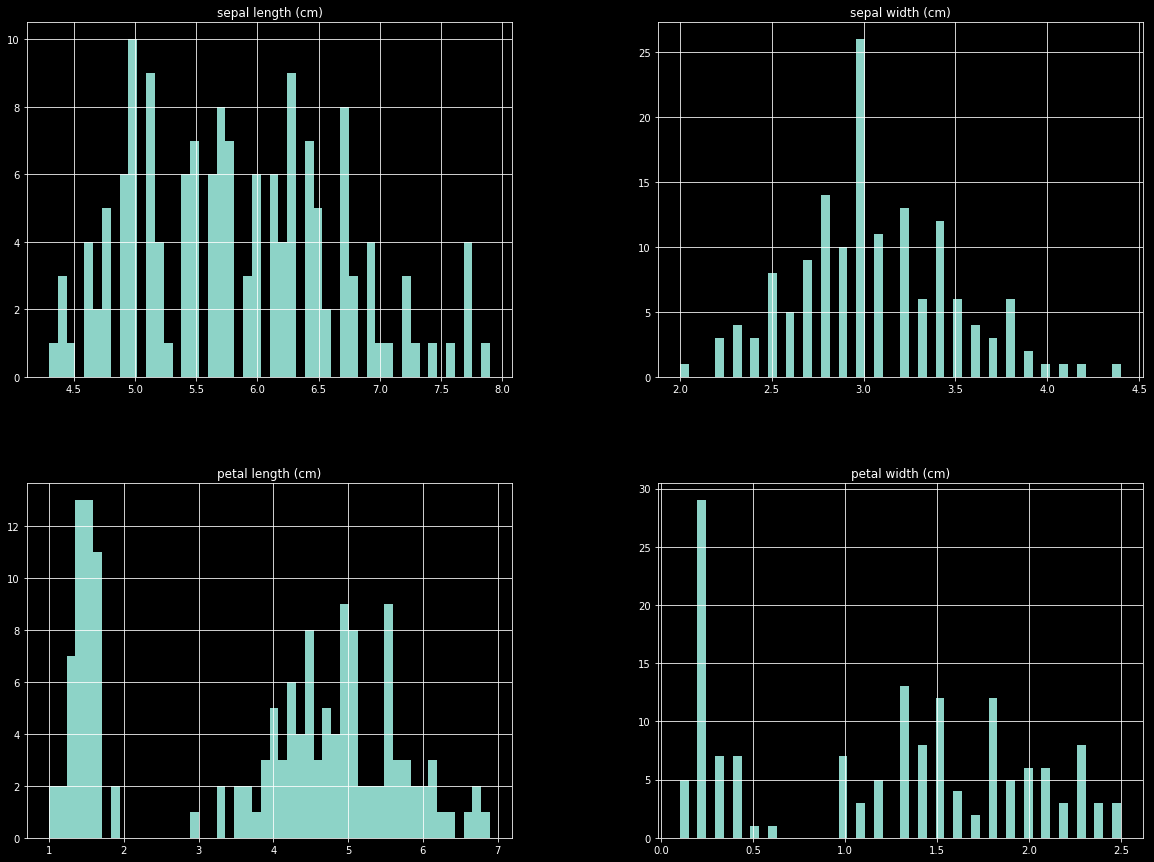

In [70]:
dataset = pd.DataFrame(data.data, columns=data.feature_names)
plot_data(dataset)

### 03. Correlation Matrix

<AxesSubplot:>

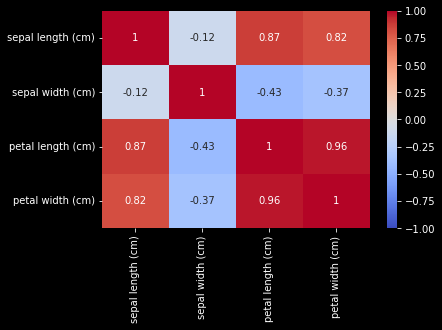

In [71]:
# Correlation data
corr = dataset.corr()

# Correlation matrix with seaborn (correlation val are -1 to 1, thats why vmin vmax)
sns.heatmap(corr, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

Meaningful correlation found between:
 - petal width & petal length (very high correlation)
 - petal width & sepal length (high correlation)


### Functions for Checking Parameters

In [72]:
from sklearn.metrics import roc_auc_score, roc_curve

# Check AOC ARC curve
def aoc_arc_curve(pred, labels_test):
    """Plots the AOC ARC curve and score"""
    auc = roc_auc_score(labels_test, pred, multi_class='ovr')
    print('AUROC score: {:.2f}'.format(auc))

    false_positive_rate, true_positive_rate, thresolds = roc_curve(labels_test, pred)

    plt.figure(figsize=(5, 4), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'y')

    plt.plot([0,1],[0,1], linestyle='dotted')

    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightyellow', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = {:.2f}'.format(auc), ha='right', fontsize=12, weight='bold')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    return auc

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def parameter_check(pred, labels_test):
    """Determines accuracy, precision, recall, f1 and aoc arc curve"""
    # Check accuracy
    accuracy = accuracy_score(labels_test , pred)

    # Check precision
    precision = precision_score(labels_test , pred, average='weighted')

    # Check recall
    recall = recall_score(labels_test , pred, average='weighted')

    # Check F1 score
    F1 = f1_score( labels_test , pred, average='weighted')

    print('Accuracy: {}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(F1))

    auc = 'NA'
    #auc = aoc_arc_curve(pred, labels_test)

    return { 'accuracy': accuracy, 'precision':precision, 'recall':recall, 'fi':F1, 'auc': auc}


### 04 Data Pre-processing

In [74]:
from sklearn.model_selection import train_test_split

# Create features and labels
features = data.data
labels = data.target

# Create training (75%) and test (25%) sets
features_train, features_test , labels_train , labels_test = train_test_split(features, labels, test_size =0.25)

### 04.1 Scaling

In [75]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

### 04.2 Imputation

In [76]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer = imputer.fit(features_train_scaled)
features_train_imputated = imputer.transform(features_train_scaled)

imputer = imputer.fit(features_test_scaled)
features_test_imputated = imputer.transform(features_test_scaled)


### 04.3 Imablanced Data

#### Up-sampling  _(with `imblearn`)_

In [77]:
from imblearn.over_sampling import SMOTE

# Re-sizing the data
features_train_balanced, labels_train_balanced = SMOTE().fit_resample(features_train_imputated, labels_train)
features_test_balanced, labels_test_balanced = SMOTE().fit_resample(features_test_imputated, labels_test)


#### Down-sampling  _(with `imblearn`)_

In [78]:
from imblearn.under_sampling import RandomUnderSampler

# Re-sizing the data
rus = RandomUnderSampler(random_state=42)
features_train_balanced2, labels_train_balanced2 = rus.fit_resample(features_train_imputated, labels_train)
features_test_balanced2, labels_test_balanced2 = rus.fit_resample(features_test_imputated, labels_test)

## Run Algorithm

In [79]:
def run_classifier(classifier, features_train, labels_train, features_test, labels_test) -> dict:
    # Fit data for training into classifier
    classifier.fit(features_train , labels_train)
    # Predicting with classifier
    acc1 = accuracy_score(y_true=labels_train, y_pred=classifier.predict(features_train))
    acc2 = accuracy_score(y_true=labels_test, y_pred=classifier.predict(features_test))
    return {'accuracy (train data)': acc1, 'accuracy (test data)' : acc2}

In [80]:
def compare_parameters(classifier):
    """Parameter Comparison"""
    raw_param = run_classifier(classifier, features_train, labels_train, features_test, labels_test)
    scaled_param = run_classifier(classifier, features_train_scaled, labels_train, features_test_scaled, labels_test)
    imputed_param = run_classifier(classifier, features_train_imputated, labels_train, features_test_imputated, labels_test)
    upsamp_param = run_classifier(classifier, features_train_balanced, labels_train_balanced, features_test_balanced, labels_test_balanced)
    downsamp_param = run_classifier(classifier, features_train_balanced2, labels_train_balanced2, features_test_balanced2, labels_test_balanced2)

    # Plot out different parameters
    compare = [raw_param, scaled_param, imputed_param, downsamp_param, upsamp_param]
    headers_comparison = ['Raw', 'Scaled', 'Imputed', 'Down-sampling (Imblearn)', 'Up-sampling (Imblearn)']

    # Create dataframe for parameter comparison
    compare_df = pd.DataFrame(compare)
    compare_df["results"]=headers_comparison
    compare_df = compare_df.set_index('results', drop=True).rename_axis(None)

    # Plot
    compare_df.iplot(kind='bar', width=0.9)

In [81]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
compare_parameters(classifier)


In [82]:
# Changing the Criterion to entropy
classifier_entropy = DecisionTreeClassifier(criterion='entropy')
compare_parameters(classifier_entropy)

In [83]:
# Tne the parameters of the decision tree to increase accuracy
classifier_min_split = DecisionTreeClassifier(criterion='entropy', min_samples_split=50)
compare_parameters(classifier_min_split)

#### Visualize

In [84]:
from six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
from pydotplus import graph_from_dot_data

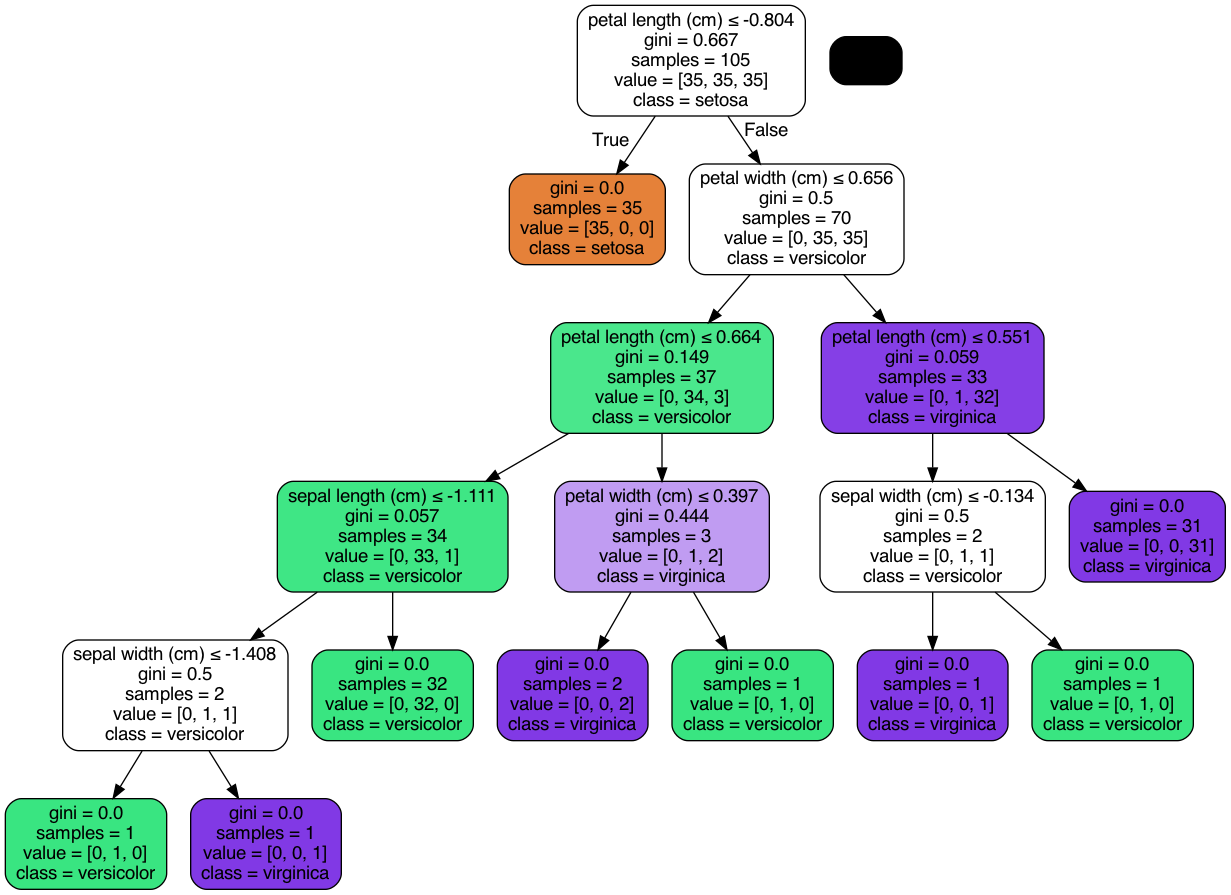

In [85]:
dot_data = StringIO()
export_graphviz(classifier,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=data.feature_names,
                class_names=data.target_names
                )
graph = graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

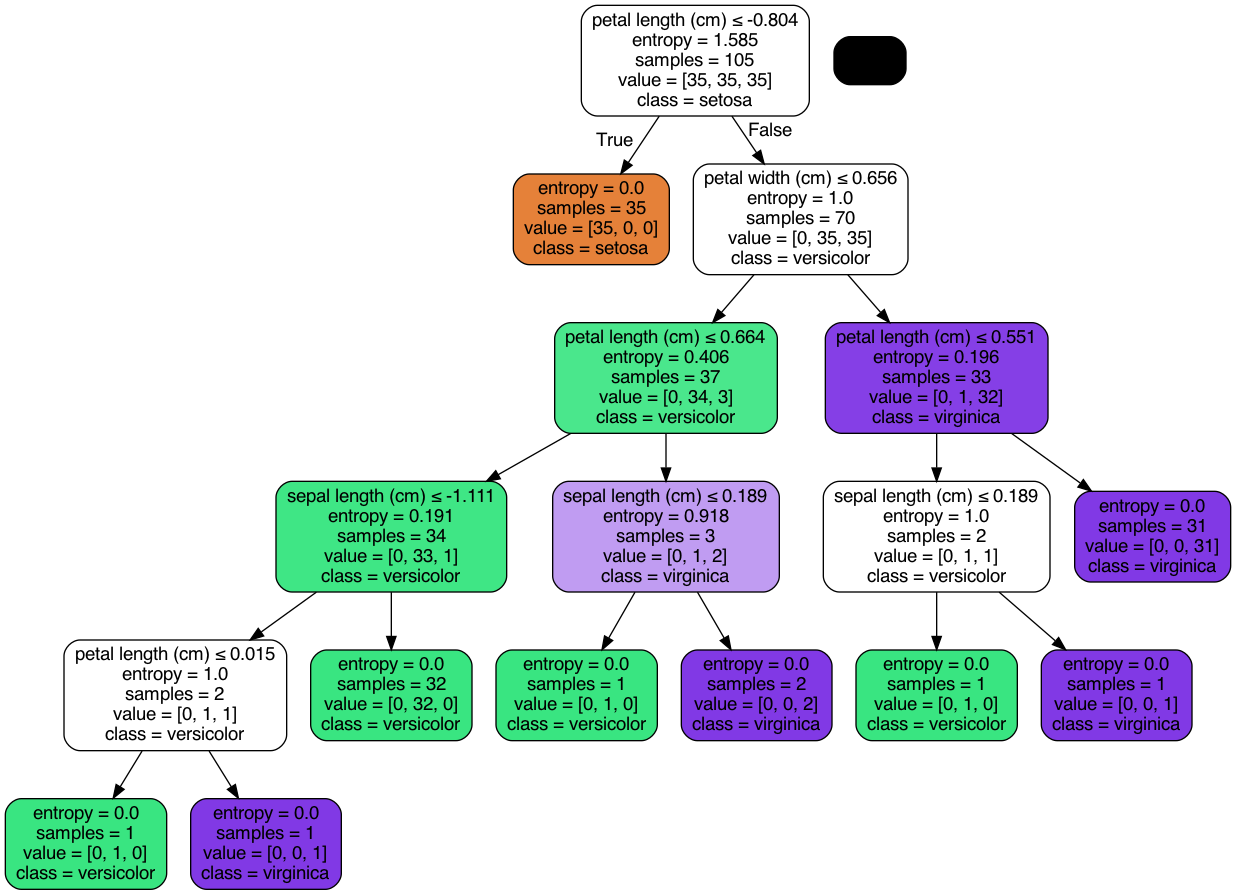

In [86]:
dot_data = StringIO()
export_graphviz(classifier_entropy,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=data.feature_names,
                class_names=data.target_names
                )
graph = graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())





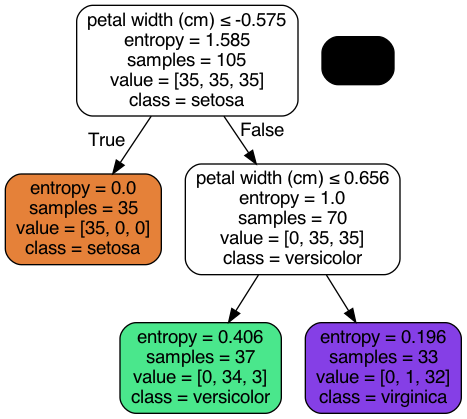

In [87]:
dot_data = StringIO()
export_graphviz(classifier_min_split,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=data.feature_names,
                class_names=data.target_names
                )
graph = graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())


